# Modeling TCLab

Alex Dowling, University of Notre Dame

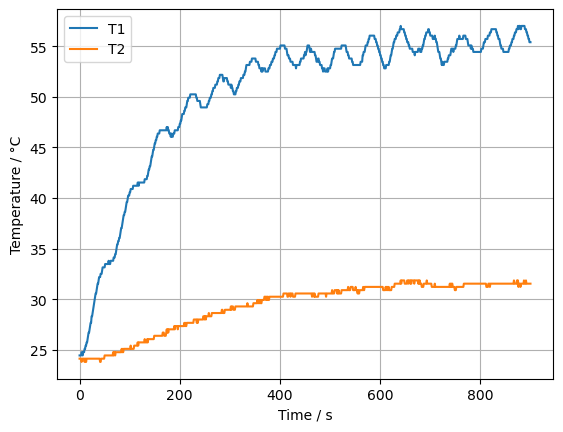

In [1]:
from FoKL import FoKLRoutines
import numpy as np
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

filename = 'tclab_sine_test.csv'

data = pd.read_csv(filename)
data.plot(x='Time', y=['T1', 'T2'], grid=True, xlabel='Time / s', ylabel='Temperature / °C')
plt.show()

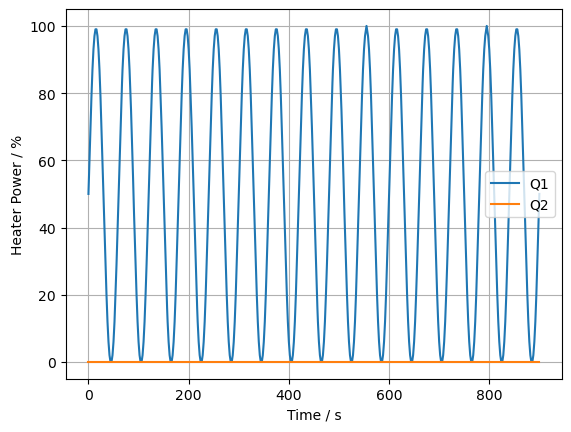

In [2]:
data.plot(x='Time', y=['Q1', 'Q2'], grid=True, xlabel='Time / s', ylabel='Heater Power / %')
plt.show()

We want to train the following mathematical model:

$$
\frac{dT_1}{dt} = f(T_1, Q_1)
$$

where $f(\cdot, \cdot)$ is the GP.

length of time vector:  901
length of derivative vector:  901
length of T1 vector:  901
length of u1 vector:  901


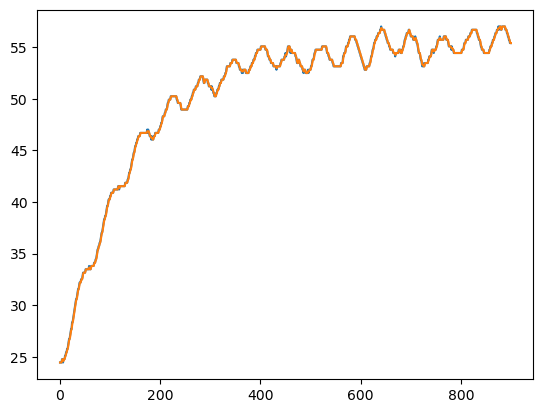

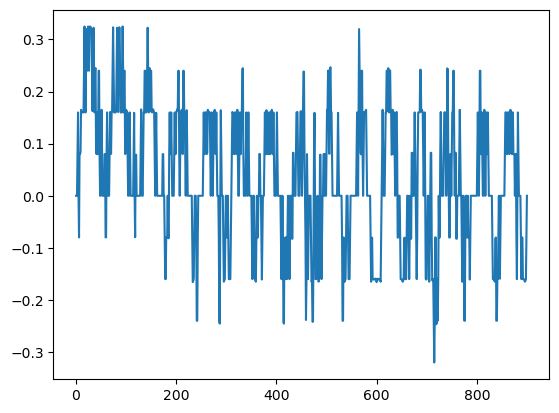

In [3]:
# TODO: look into smoothing the data, or fit smoothing GP to the data
# good chance the derivative is really noisy
# look for "smooth_diff"


ApplySmoothing = True

# -----------------------------------------

T1 = data['T1']

if ApplySmoothing is True:
    # apply rolling mean to smooth the data
    window = 2
    T1_smooth = T1.rolling(window=window).mean()

    # copy the first window values to the beginning of the smoothed data
    T1_smooth[0:window] = T1.values[0:window]

    T1 = T1_smooth

# define the time vector
t = data['Time'].values
print("length of time vector: ", len(t))

# calculate the derivative of the smoothed data
dT1dt = np.gradient(T1, t)
print("length of derivative vector: ", len(dT1dt))

# calculate Tamb
Tamb = T1[0]

print("length of T1 vector: ", len(T1))

u1 = data['Q1'].values
print("length of u1 vector: ", len(u1))

plt.figure()
if ApplySmoothing is True:
    plt.plot(t, data['T1'], label='T1 (raw)')
    plt.plot(t, T1, label='T1 (smooth)')
else:
    plt.plot(t, T1, label='T1')  # raw
plt.show()

plt.figure()
plt.plot(t, dT1dt)

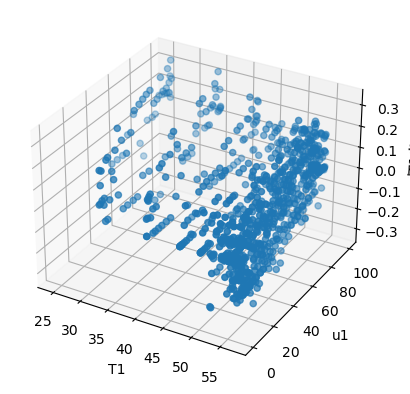

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(T1, u1, dT1dt)
ax.set_xlabel('T1')
ax.set_ylabel('u1')
ax.set_zlabel('dT1dt')
plt.show()

## Train Model

In [5]:
# f = FoKLRoutines.FoKL(kernel=1, gimmie=True, aic=True, tolerance=15, UserWarnings=True)
f = FoKLRoutines.FoKL(kernel=1, aic=True, tolerance=12, a=1000, b=1, draws=2000, threshav=0, threshstda=0, threshstdb=100, UserWarnings=True)
print("\nTraining FoKL model...")
betas, mtx, evs = f.fit([T1 - Tamb, u1], dT1dt, clean=True)
print("Done!")
f.save('attempt1.fokl')


Training FoKL model...


/home/jacobpatrick/.local/lib/python3.12/site-packages/FoKL/FoKLRoutines.py:292: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, -3027.1448880878465]
[2, -3025.6171826940163]
[2, -3024.199938330116]
[3, -3021.2566339050272]
[3, -3041.866588425321]
[4, -3040.2535683661167]
[4, -3042.1635117121205]
[4, -3039.8584531743295]
[5, -3048.539244538517]
[5, -3049.8257510764643]
[5, -3067.5320396544903]
[6, -3067.158955635032]
[6, -3075.9296915773084]
[6, -3071.9490817099067]
[6, -3072.772628699007]
[7, -3070.7282935156845]
[7, -3071.778597229283]
[7, -3068.570081231995]
[7, -3087.6444283657806]
[8, -3086.6903955367625]
[8, -3082.920594958845]
[8, -3079.423953074271]
[8, -3076.416789077991]
[8, -3079.6541420405683]
[9, -3078.0966571896734]
[9, -3077.281114284739]
[9, -3074.121340296848]
[9, -3071.7372542362423]
[9, -3078.097182352113]
[10, -3078.097182352113]
[10, -3075.362565468491]
Done!


'attempt1.fokl'

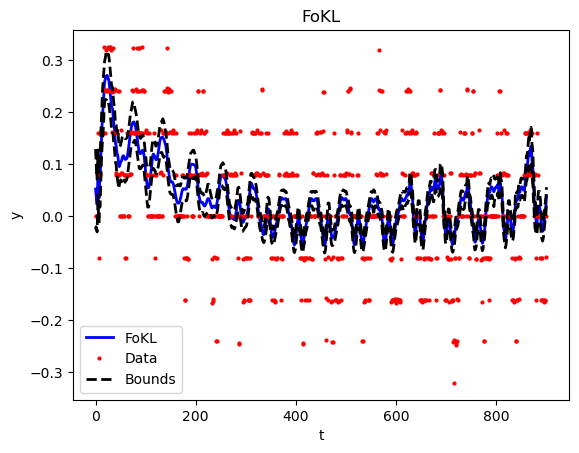

In [6]:
# Plot to visualize dataset and model:
_ = f.coverage3(plot=True, xlabel='t', xaxis=t, ylabel='y')

In [7]:
dT1dt_pred = f.evaluate()  # == f.evaluate([T1_smooth - Tamb, u1], betas, mtx), by default

In [8]:
dt = np.gradient(t)

In [37]:
# FAILED ATTEMP AT USING GP_Integrate:


import os
import sys
sys.path.append(os.path.join('..', '..'))  # include local path (i.e., this package)
from src.FoKL.GP_Integrate import GP_Integrate


betas_avg = [np.mean(f.betas, axis=0)]
b = np.zeros_like(t)  # f.inputs, doesn't make sense
norms = np.transpose([f.normalize[0], f.normalize[1]])
stepsize = np.mean(dt)  # assume constant step size

# used_inputs = [[1, 0]] # [T1, Q1, b]
used_inputs = [[1]]
ic = np.array([T1[0], u1[0]])  # initial conditions

T1_pred, int_Y = GP_Integrate(betas_avg, [f.mtx], b, norms, f.phis, t[0], t[-1], ic, stepsize, used_inputs, kernel=1)


b=1

IndexError: list index out of range

In [ ]:
# This is a very simple integration of the derivative to get the prediction
# T1_pred = np.cumsum(dT1dt_pred*dt)

plt.plot(t, T1_smooth, label='T1 data', marker='o')
plt.plot(t, T1_pred + Tamb, label='T1 prediction', linestyle='-')
plt.legend()
plt.show()